In [190]:
import os
import numpy as np
import pandas as pd
import json
from parallel_robust_forest import load_attack_rules
from sklearn.model_selection import train_test_split
from joblib import Parallel,delayed

In [191]:
SEED = 42

# Functions

In [3]:
# Functions

def load_dataset(path, 
                 dataset_filename, 
                 sep=",", 
                 header=None,
                 nrows=None,
                 names=None, 
                 index_col=False, 
                 na_values='?'):
    
    return pd.read_csv(os.path.join(path,dataset_filename), 
                       sep=sep, 
                       header=header,
                       nrows=nrows,
                       names=names, 
                       index_col=index_col, 
                       na_values='?')

def binarize_data(data, label, threshold):
    data[label] = np.where(data[label] >= threshold, 1, -1)

    
def discretize(datasets, n_bins, skip_columns=[]):
    full = pd.concat(datasets)
    for col in full.columns.values:
        if not col in skip_columns:
            # process full
            new_col, bins = pd.qcut(full[col], n_bins, duplicates='drop', retbins=True, labels=False)
            # apply other
            for d in datasets:
                new_col = pd.cut(d[col], bins, labels=False, include_lowest=True)  
                d[col] = bins[new_col]
def serialize_dataset(p_data, 
                      path, 
                      dataset_filename, 
                      suffix, 
                      sep=",", 
                      compression="bz2", 
                      index=False):
    
    p_data.to_csv(path+"/"+dataset_filename.split(".")[0]+suffix, 
                  sep=sep, 
                  compression=compression, 
                  index=index)

In [4]:
def perturb_instance(x_orig, rules, budget, max_budget_per_feature, thresholds):
    """
    Returns the set of possible perturbations of a given instance.

    This function takes as input an instance and returns a set of perturbations of that instance, 
    using the specified amount of budget and considering the cost of perturbing each individual feature.

    Parameters
    ----------
    x : pandas.Series
        The original instance
    rules : list
        The list of modification rules
    budget : float
        The attacker's budget
    max_budget_per_feature : dict
        The maximum allowed amount of budget units that can be spend on each feature
    thresholds : dict
        feature -> list of relevant thresholds 

    Returns
    -------
    pandas.DataFrame
        The set of perturbations (including the original instance, placed at the very beginning)
    """

    # initialize the queue (FIFO) with both the original instance, 
    # the initial budget, and an empty dictionary of budget units spent so far
    queue = [(x_orig, budget, {})]
    # visited perturbations
    seen = { tuple(x_orig): [budget, {}] }
    # initialize the set of perturbations of this instance with the empty list
    # perturbations = []
    
    # loop until the queue is not empty
    while len(queue)>0:
        item = queue.pop() # dequeue the first inserted element
        x = item[0] # get the instance
        b = item[1] # get the residual budget
        budget_units_spent = item[2] # get the dictionary containing the amount of budget spent on each feature, so far
        
        # loop through all the features subject to the set of attack rules
        for r in rules:
            f = x.index.values[r.get_target_feature()]
            # check budget
            if not( r.get_cost() <= b and 
                   budget_units_spent.get(f, 0) + r.get_cost() <= max_budget_per_feature[f] ):
                continue
            # check validity
            if not r.is_applicable(x):
                continue
            
            # apply rule to a copy
            x_atks = []
            if not r.is_num():
                xx = r.apply(x)
                x_atks += [xx]
            else:
                x_tmp = r.apply(x)
                # Evaluate crossing of multiple thresholds
                low,high=sorted([x[f], x_tmp[f]])
                z = set(thresholds[f][np.logical_and(thresholds[f]>=low, thresholds[f]<=high)])
                z |= set([low,high])
                # Evaluate extremes of validity interval
                extremes = r.get_pre_interval()
                z |= set([t for t in extremes if low < t < high])
                
                for zi in z:
                    xx = x.copy()
                    xx[f] = zi
                    x_atks += [xx]

            # process all atks
            for xx in x_atks:
                # skip if already seen and with a larger residual budget
                xx_t = tuple(xx)
                res_b = b - r.get_cost()
                seen_budgets = seen.get(xx_t)
                if seen_budgets is not None and seen_budgets[0] >= res_b:
                    continue

                # update budgets spent
                updated_budget_units_spent = budget_units_spent.copy()
                updated_budget_units_spent[f] = updated_budget_units_spent.get(f,0) + r.get_cost()
                # add to frontier and to past seen elements
                seen[xx_t] = [res_b, updated_budget_units_spent]
                queue.append([xx, res_b, updated_budget_units_spent])
    
    perturbations_df = pd.DataFrame.from_records(list(seen.keys()), columns=x_orig.index.values)
    perturbations_df = perturbations_df.drop_duplicates()
    perturbations_df = pd.concat([pd.DataFrame.from_records([x_orig], columns=x_orig.index.values),perturbations_df])
    return perturbations_df

In [5]:
def perturb_thread(x, rules, budget, max_budget_per_feature, thresholds,skip_class,instance_id =-1):
    
    if instance_id%500==0:
        print("***** Perturbing instance [ID = #{}]... *****".format(instance_id))  
        
    if skip_class is not None and instance[-1]==skip_class:
        # keep the original instance only
        perturbations = pd.DataFrame([x])
    else:
            
        perturbations = perturb_instance(x_orig=x, rules=rules, budget=budget, 
                                             max_budget_per_feature=max_budget_per_feature,
                                             thresholds=thresholds) 
            
    perturbations.insert(loc=0,  column="instance_id", 
                            value=[instance_id for i in range(perturbations.shape[0])], 
                            allow_duplicates=True)
    return perturbations

In [6]:
def perturb_dataset(data, budget, max_budget_per_feature, rules, skip_class=None):
    """
    Returns the dataset extended with all instance perturbations.

    This function takes as input a dataset and returns another dataset which is obtained from the original
    by adding all the possible perturbations an attacker with budget B can apply to every instance.

    Parameters
    ----------
    data : pandas.DataFrame
        The original dataset
    rules : list
        The list of modification rules
    budget : float
        The attacker's budget
    max_budget_per_feature : dict
        The maximum allowed amount of budget units that can be spend on each feature
    costs : dict
        A mapping between each feature and its cost of perturbation
    skip_class : int
        if class (i.e. last columns) equals skip_class, then instance is skipped

    Returns
    -------
    pandas.DataFrame
        The perturbed dataset

    """
    if data is None or data.empty:
        return # if not, just return None
    
    # compute valid thresholds
    thresholds = {c:np.unique(data[c]) for c in data.columns}

    # prepare the perturbed dataset to be returned, initially empty with an extra "instance_id" column
    cols = ["instance_id"] + data.columns.tolist()
    perturbed_data = pd.DataFrame(columns=cols)
    
    perturbed_data = Parallel(n_jobs=24)(delayed(perturb_thread)
                                             (x=instance, rules=rules, budget=budget,
                                                max_budget_per_feature=max_budget_per_feature,
                                                thresholds=thresholds, skip_class=skip_class,
                                                instance_id=instance_id+1) # start from id 1
                                        for instance_id,(index, instance) in enumerate(data.iterrows()))
    
    perturbed_data = pd.concat(perturbed_data)
    
    # eventually, return the perturbed dataset
    print("***** Return the final perturbed dataset *****")
    
    return perturbed_data

# WINE Dataset

In [ ]:
DATASET_NAME="wine"

raw_colnames = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
            'total_sulfur_dioxide', 'density', 'pH', 'sulphites', 'alcohol', 'is_white', 'quality']

DATASET_PATH="../data/{}".format(DATASET_NAME)
RAW_DATASET_PATH=DATASET_PATH + "/raw"
ATK_DATASET_PATH=DATASET_PATH + "/attacks"

ATKS_FILE = os.path.join(ATK_DATASET_PATH, "attacks.json")

TRAINING_SET="train.csv.bz2"
VALIDATION_SET="valid.csv.bz2"
TEST_SET="test.csv.bz2"
N_TRAIN_INSTANCES=None # replace this with None to load the whole training set
N_TEST_INSTANCES=None # replace this with None to load the whole test set

In [ ]:
# load
train = load_dataset(RAW_DATASET_PATH, TRAINING_SET, names=raw_colnames, header=0, nrows=N_TRAIN_INSTANCES)
valid = load_dataset(RAW_DATASET_PATH, VALIDATION_SET, names=raw_colnames, header=0)
test  = load_dataset(RAW_DATASET_PATH, TEST_SET, names=raw_colnames, header=0, nrows=N_TEST_INSTANCES)

# binarize
binarize_data(train, "quality", 6)
binarize_data(valid, "quality", 6)
binarize_data(test, "quality", 6)

#discretize
discretize([train, valid, test], 128, ["quality"])

print("Shape of training set: {}".format(train.shape))
print("Shape of validation set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))

serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")
serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")
serialize_dataset(test, DATASET_PATH, TEST_SET, ".csv.bz2")

#train.head()
# valid.head()
# test.head()

In [ ]:
## WITH ATTACKS

######################
# Attacker Definition
######################

max_budget_per_feature = {
    'alcohol'          : 1000,
    'residual_sugar'   : 1000,
    'volatile_acidity' : 1000,
    'free_sulfur_dioxide' :1000
}

attacker_rules = load_attack_rules(ATKS_FILE, list(train.columns.values) )

B = [100,120]


for budget in B:
    print ("Processing Budget: ", budget)
    train_att = perturb_dataset(train, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    valid_att = perturb_dataset(valid, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    test_att  = perturb_dataset(test, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    
    serialize_dataset(train_att, ATK_DATASET_PATH, TRAINING_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(valid_att, ATK_DATASET_PATH, VALIDATION_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(test_att, ATK_DATASET_PATH, TEST_SET, "_B{}".format(budget)+".atks.bz2")
    
    print("Shape of attacked training set: {}".format(train_att.shape))
    print("Shape of attacked validation set: {}".format(valid_att.shape))
    print("Shape of attacked test set: {}".format(test_att.shape))

# CENSUS Dataset

In [ ]:
DATASET_NAME="census"

raw_colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
                'hours_per_week', 'native_country', 'income_greater_than_50k']

DATASET_PATH="../data/{}".format(DATASET_NAME)
RAW_DATASET_PATH=DATASET_PATH + "/raw"
ATK_DATASET_PATH=DATASET_PATH + "/attacks"

ATKS_FILE = os.path.join(ATK_DATASET_PATH, "attacks.json")

TRAINING_SET="train.csv.bz2"
VALIDATION_SET="valid.csv.bz2"
TEST_SET="test.csv.bz2"

N_TRAIN_INSTANCES=None # replace this with None to load the whole training set
N_TEST_INSTANCES=None # replace this with None to load the whole test set



In [ ]:
## WITHOUT ATTACKS

# load
train = load_dataset(RAW_DATASET_PATH, TRAINING_SET, names=raw_colnames, header=0, nrows=N_TRAIN_INSTANCES)
test = load_dataset(RAW_DATASET_PATH, TEST_SET, names=raw_colnames, header=0, nrows=N_TEST_INSTANCES)

# remove education string
train = train.drop(['education'], axis=1)
test  = test.drop(['education'], axis=1)
# drop NA
train = train[~train.isnull().any(axis=1)]
test  = test[~test.isnull().any(axis=1)]

# create the missing validation set
train, valid = train_test_split( train, 
                                 test_size=0.1, 
                                 random_state=42, 
                                 stratify=train["income_greater_than_50k"])

print("Shape of training set: {}".format(train.shape))
print("Shape of validation set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))

serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")
serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")
serialize_dataset(test, DATASET_PATH, TEST_SET, ".csv.bz2")


# train.head()
# valid.head()
# test.head()

In [ ]:
## WITH ATTACKS

######################
# Attacker Definition
######################
max_budget_per_feature = {
    'workclass'     : 1000,
    'marital_status': 1000,
    'occupation'    : 1000,
    'education_num' : 1000,
    'hours_per_week': 1000,
    'capital_gain'  : 1000
}

B = [30,60] # 90

attacker_rules = load_attack_rules(ATKS_FILE, list(train.columns.values) )

for budget in B:
    print ("Processing Budget: ", budget)
    train_att = perturb_dataset(train, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    valid_att = perturb_dataset(valid, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    test_att  = perturb_dataset(test, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    
    serialize_dataset(train_att, ATK_DATASET_PATH, TRAINING_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(valid_att, ATK_DATASET_PATH, VALIDATION_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(test_att, ATK_DATASET_PATH, TEST_SET, "_B{}".format(budget)+".atks.bz2")
    
    print("Shape of attacked training set: {}".format(train_att.shape))
    print("Shape of attacked validation set: {}".format(valid_att.shape))
    print("Shape of attacked test set: {}".format(test_att.shape))

# SPAM Dataset

In [ ]:
DATASET_NAME="spam"

colnames = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',
       'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!',
       'char_freq_$', 'char_freq_#', 'capital_run_length_average',
       'capital_run_length_longest', 'capital_run_length_total', 'spam']

DATASET_PATH="../data/{}".format(DATASET_NAME)
RAW_DATASET_PATH=DATASET_PATH + "/raw"
ATK_DATASET_PATH=DATASET_PATH + "/attacks"

ATKS_FILE = os.path.join(ATK_DATASET_PATH, "attacks.json")

TRAINING_SET="train.csv.bz2"
VALIDATION_SET="valid.csv.bz2"
TEST_SET="test.csv.bz2"
N_TRAIN_INSTANCES=None # replace this with None to load the whole training set
N_TEST_INSTANCES=None # replace this with None to load the whole test set




In [ ]:
train = pd.read_csv(os.path.join(RAW_DATASET_PATH, "spam.csv"))
train['class'] = train['class'].map({1: 1, 0: -1})

train = train.sample(frac=1).reset_index(drop=True) #to reshuffle

print("Number of instances = {}\nNumber of features = {}".format(train.shape[0], train.shape[1] - 1))
print("Class distribution:\n{}".format(train['class'].value_counts()))
print("Class distribution:\n{}".format(train['class'].value_counts()/len(train)))

In [ ]:
train_size = int(len(train)*.6)
valid_size = int(len(train)*.2)

valid = train[train_size:train_size+valid_size]
test  = train[train_size+valid_size:]
train = train[:train_size]


print("Shape of training set: {}".format(train.shape))
print("Shape of validation set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))
print("Class distribution:\n{}".format(train['class'].value_counts()/len(train)))

print("Class distribution:\n{}".format(valid['class'].value_counts()/len(valid)))

print("Class distribution:\n{}".format(test['class'].value_counts()/len(test)))

In [ ]:
# load
#train = load_dataset(RAW_DATASET_PATH, TRAINING_SET, names=colnames, header=0, nrows=N_TRAIN_INSTANCES)
#valid = load_dataset(RAW_DATASET_PATH, VALIDATION_SET, names=colnames, header=0)
#test = load_dataset(RAW_DATASET_PATH, TEST_SET, names=colnames, header=0, nrows=N_TEST_INSTANCES)

# binarize
binarize_data(train, "class", 0.5)
binarize_data(valid, "class", 0.5)
binarize_data(test, "class", 0.5)

#discretize
discretize([train, valid, test], 64, ["class"])

print("Shape of training set: {}".format(train.shape))
print("Shape of validation set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))

serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")
serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")
serialize_dataset(test, DATASET_PATH, TEST_SET, ".csv.bz2")

# train.head()
# valid.head()
# test.head()

In [ ]:
max_budget_per_feature = {
    'char_freq_!'     : 1000,
    'word_freq_remove': 1000,
    'char_freq_$'     : 1000,
    'capital_run_length_average' : 1000,
    'capital_run_length_total': 1000,
    'word_freq_hp'  : 1000
}

B = [50, 60 ]
attacker_rules = load_attack_rules(ATKS_FILE, list(train.columns.values) )
for budget in B:
    print ("Processing Budget: ", budget)
    train_att = perturb_dataset(train, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    valid_att = perturb_dataset(valid, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    test_att  = perturb_dataset(test, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    
    serialize_dataset(train_att, ATK_DATASET_PATH, TRAINING_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(valid_att, ATK_DATASET_PATH, VALIDATION_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(test_att, ATK_DATASET_PATH, TEST_SET, "_B{}".format(budget)+".atks.bz2")
    
    print("Shape of attacked training set: {}".format(train_att.shape))
    print("Shape of attacked validation set: {}".format(valid_att.shape))
    print("Shape of attacked test set: {}".format(test_att.shape))

# CREDIT Dataset

In [ ]:
DATASET_NAME="credit"

DATASET_PATH="../data/{}".format(DATASET_NAME)
RAW_DATASET_PATH=DATASET_PATH + "/raw"
ATK_DATASET_PATH=DATASET_PATH + "/attacks"

ATKS_FILE = os.path.join(ATK_DATASET_PATH, "attacks.json")

TRAINING_SET="train.csv.bz2"
VALIDATION_SET="valid.csv.bz2"
TEST_SET="test.csv.bz2"
N_TRAIN_INSTANCES=None # replace this with None to load the whole training set
N_TEST_INSTANCES=None # replace this with None to load the whole test set

In [ ]:
train = pd.read_csv(os.path.join(RAW_DATASET_PATH, "credit.csv"))
train.drop(columns="ID", inplace=True)

binarize_data(train, "default.payment.next.month", .5)

discretize([train], 128, ["default.payment.next.month"])

print("Number of instances = {}\nNumber of features = {}".format(train.shape[0], train.shape[1] - 1))
print("Class distribution:\n{}".format(train['default.payment.next.month'].value_counts()))

In [ ]:
# Take a (stratified) sample of N = 6,000 instances (i.e., 20%) out of the whole dataset
#y = train["default.payment.next.month"].to_frame()
#X = train
#_, X_test, _, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [ ]:
train.head()

In [ ]:
train_size = int(len(train)*.6)
valid_size = int(len(train)*.2)

valid = train[train_size:train_size+valid_size]
test  = train[train_size+valid_size:]
train =  train[:train_size]

print("Shape of training set: {}".format(train.shape))
print("Shape of validation set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))

serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")
serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")
serialize_dataset(test, DATASET_PATH, TEST_SET, ".csv.bz2")

# train.head()
# valid.head()
# test.head()

In [ ]:
## WITH ATTACKS

######################
# Attacker Definition
######################
max_budget_per_feature = {
    'PAY_0'     : 1000,
    'BILL_AMT1': 1000,
    'PAY_2'    : 1000,
    'LIMIT_BAL' : 1000
}

B = [10,30,40,60] # 90

attacker_rules = load_attack_rules(ATKS_FILE, list(train.columns.values) )

for budget in B:
    print ("Processing Budget: ", budget)
    train_att = perturb_dataset(train, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    valid_att = perturb_dataset(valid, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    test_att  = perturb_dataset(test, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    
    serialize_dataset(train_att, ATK_DATASET_PATH, TRAINING_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(valid_att, ATK_DATASET_PATH, VALIDATION_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(test_att, ATK_DATASET_PATH, TEST_SET, "_B{}".format(budget)+".atks.bz2")
    
    print("Shape of attacked training set: {}".format(train_att.shape))
    print("Shape of attacked validation set: {}".format(valid_att.shape))
    print("Shape of attacked test set: {}".format(test_att.shape))

# WEBSITES Dataset

In [ ]:
DATASET_NAME="websites"

DATASET_PATH="../data/{}".format(DATASET_NAME)
RAW_DATASET_PATH=DATASET_PATH + "/raw"
ATK_DATASET_PATH=DATASET_PATH + "/attacks"

ATKS_FILE = os.path.join(ATK_DATASET_PATH, "attacks.json")

TRAINING_SET="train.csv.bz2"
VALIDATION_SET="valid.csv.bz2"
TEST_SET="test.csv.bz2"
N_TRAIN_INSTANCES=None # replace this with None to load the whole training set
N_TEST_INSTANCES=None # replace this with None to load the whole test set

In [ ]:
train = pd.read_csv(os.path.join(RAW_DATASET_PATH, "dataset.csv"))

train.drop(columns=['URL'], inplace=True)
train["CONTENT_LENGTH"] = train["CONTENT_LENGTH"].fillna(0)
train.drop(columns=['WHOIS_REGDATE','WHOIS_UPDATED_DATE'], inplace=True)
train.dropna(inplace=True)

print("Number of instances = {}\nNumber of features = {}".format(train.shape[0], train.shape[1] - 1))
print("Class distribution:\n{}".format(train['Type'].value_counts()))

In [ ]:
# train['SERVER'].apply(lambda x: "codfw.wmnet" if "codfw.wmnet" in str(x) else str(x).split("/")[0] ).value_counts()

In [ ]:
train.info()

In [ ]:
# Take a (stratified) sample of N = 350 instances (i.e., 20%) out of the whole dataset
#y = train["Type"].to_frame()
#X = train
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [ ]:
train_size = int(len(train)*.6)
valid_size = int(len(train)*.2)

valid = train[train_size:train_size+valid_size]
test  = train[train_size+valid_size:]
train = train[:train_size]

print("Shape of training set: {}".format(train.shape))
print("Shape of validation set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))

# binarize
binarize_data(train, "Type", 0.5)
binarize_data(valid, "Type", 0.5)
binarize_data(test, "Type", 0.5)

#discretize
discretize([train, valid, test], 128, ["Type", "CHARSET", "SERVER", "WHOIS_COUNTRY", "WHOIS_STATEPRO"])

serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")
serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")
serialize_dataset(test, DATASET_PATH, TEST_SET, ".csv.bz2")

In [ ]:
## WITH ATTACKS

######################
# Attacker Definition
######################
max_budget_per_feature = {
    'NUMBER_SPECIAL_CHARACTERS': 1000,
    'URL_LENGTH': 1000,
    'CONTENT_LENGTH': 1000,
    'REMOTE_APP_BYTES' : 1000,
    'APP_BYTES' :1000
}

B = [10,30] # 90

attacker_rules = load_attack_rules(ATKS_FILE, list(train.columns.values) )

for budget in B:
    print ("Processing Budget: ", budget)
    train_att = perturb_dataset(train, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    valid_att = perturb_dataset(valid, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    test_att  = perturb_dataset(test, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    
    serialize_dataset(train_att, ATK_DATASET_PATH, TRAINING_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(valid_att, ATK_DATASET_PATH, VALIDATION_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(test_att, ATK_DATASET_PATH, TEST_SET, "_B{}".format(budget)+".atks.bz2")
    
    print("Shape of attacked training set: {}".format(train_att.shape))
    print("Shape of attacked validation set: {}".format(valid_att.shape))
    print("Shape of attacked test set: {}".format(test_att.shape))

# Financial Distress

In [ ]:
DATASET_NAME="financial"

DATASET_PATH="../data/{}".format(DATASET_NAME)
RAW_DATASET_PATH=DATASET_PATH + "/raw"
ATK_DATASET_PATH=DATASET_PATH + "/attacks"

ATKS_FILE = os.path.join(ATK_DATASET_PATH, "attacks.json")

TRAINING_SET="train.csv.bz2"
VALIDATION_SET="valid.csv.bz2"
TEST_SET="test.csv.bz2"
N_TRAIN_INSTANCES=None # replace this with None to load the whole training set
N_TEST_INSTANCES=None # replace this with None to load the whole test set

In [ ]:
train = pd.read_csv(os.path.join(RAW_DATASET_PATH, "dataset.csv"))

binarize_data(train, "Financial Distress", 0)

# drop company and time
train.drop(columns=['Company', 'Time'], inplace=True)

# 80 is categorical
train['x80'] = train['x80'].astype("category")

discretize([train], 256, ["Financial Distress", 'x80'])

# put label in last column
train = pd.concat([train.iloc[:,1:], train.iloc[:,0]], axis=1)

print("Number of instances = {}\nNumber of features = {}".format(train.shape[0], train.shape[1] - 1))
print("Class distribution:\n{}".format(train['Financial Distress'].value_counts()))

In [ ]:
# Stratified sampling
positive = train[train['Financial Distress']>0]
negative = train[train['Financial Distress']<0]

train_pos_size = int(len(positive)*.6)
valid_pos_size = int(len(positive)*.2)
train_neg_size = int(len(negative)*.6)
valid_neg_size = int(len(negative)*.2)

valid = pd.concat([positive[train_pos_size:train_pos_size+valid_pos_size], 
                   negative[train_neg_size:train_neg_size+valid_neg_size]]) 
test  = pd.concat([positive[train_pos_size+valid_pos_size:], 
                   negative[train_neg_size+valid_neg_size:]]) 
train = pd.concat([positive[:train_pos_size], 
                   negative[:train_neg_size]]) 

print("Shape of training set: {}".format(train.shape))
print("Shape of validation set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))

serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")
serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")
serialize_dataset(test, DATASET_PATH, TEST_SET, ".csv.bz2")

In [ ]:
train.describe().iloc[:,38:55]

# Feature importance 

In [ ]:
import lightgbm
def print_fx_imp(model, colnames):
    fx_uses = model.feature_importance(importance_type='split')
    fx_gain = model.feature_importance(importance_type='gain')

    for i,f in enumerate(np.argsort(fx_gain)[::-1]):
        print ("{:2d} {:20s} {:.3f} {:4d}".format(i, colnames[f], fx_gain[f], fx_uses[f]))

print("-- GDBT --")    
#gbdt = lightgbm.Booster(model_file="../out/models/census/std-gbdt_census_T100_S0050_L24_R100.model")
gbdt = lightgbm.Booster(model_file="../out/models/financial/std-gbdt_financial_T100_S0010_L256_R100.model")
print(gbdt.num_trees())
print_fx_imp(gbdt, train.columns)

In [ ]:
## WITH ATTACKS

######################
# Attacker Definition
######################
max_budget_per_feature = {
    'x36': 1000,
    'x81': 1000,
    'x47': 1000,
    'x37': 1000,
    'x40':1000,
    'x3':1000,
    'x16':1000,
    'x52':1000
    
}

B = [10] # 90

attacker_rules = load_attack_rules(ATKS_FILE, list(train.columns.values) )

for budget in B:
    print ("Processing Budget: ", budget)
    train_att = perturb_dataset(train, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    valid_att = perturb_dataset(valid, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    test_att  = perturb_dataset(test, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    
    serialize_dataset(train_att, ATK_DATASET_PATH, TRAINING_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(valid_att, ATK_DATASET_PATH, VALIDATION_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(test_att, ATK_DATASET_PATH, TEST_SET, "_B{}".format(budget)+".atks.bz2")
    
    print("Shape of attacked training set: {}".format(train_att.shape))
    print("Shape of attacked validation set: {}".format(valid_att.shape))
    print("Shape of attacked test set: {}".format(test_att.shape))

# malware

In [7]:
DATASET_NAME="malware"

DATASET_PATH="../data/{}".format(DATASET_NAME)
RAW_DATASET_PATH=DATASET_PATH + "/raw"
ATK_DATASET_PATH=DATASET_PATH + "/attacks"

ATKS_FILE = os.path.join(ATK_DATASET_PATH, "attacks.json")

TRAINING_SET="train.csv.bz2"
VALIDATION_SET="valid.csv.bz2"
TEST_SET="test.csv.bz2"
N_TRAIN_INSTANCES=None # replace this with None to load the whole training set
N_TEST_INSTANCES=None # replace this with None to load the whole test set

In [8]:
train = pd.read_csv(os.path.join(RAW_DATASET_PATH, "malware.csv"))

train.drop(columns=['hash'], inplace=True)


train['malware'] = train['malware'].map({1: 1, 0: -1})
train = train.sample(frac=1).reset_index(drop=True)


print("Number of instances = {}\nNumber of features = {}".format(train.shape[0], train.shape[1] - 1))
print("Class distribution:\n{}".format(train['malware'].value_counts()))
print("Class distribution:\n{}".format(train['malware'].value_counts()/len(train)))


Number of instances = 47580
Number of features = 1000
Class distribution:
 1    45651
-1     1929
Name: malware, dtype: int64
Class distribution:
 1    0.959458
-1    0.040542
Name: malware, dtype: float64


In [9]:
#index =[844,822,29]
#train.columns[957]
#train.columns.get_loc("exit")

In [10]:
train_size = int(len(train)*.6)
valid_size = int(len(train)*.2)

valid = train[train_size:train_size+valid_size]
test  = train[train_size+valid_size:]
train = train[:train_size]

print("Shape of test set: {}".format(test.shape))
#print("Class distribution:\n{}".format(test['malware'].value_counts()/len(valid)))

print("Class distribution:\n{}".format(test['malware'].value_counts()/len(test)))

#serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")
#serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")


# binarize

#binarize_data(test, "quality", 6)

#discretize
#discretize([train, valid, test], 128, ["quality"])

serialize_dataset(test, DATASET_PATH, TEST_SET, ".csv.bz2")

Shape of test set: (9516, 1001)
Class distribution:
 1    0.96322
-1    0.03678
Name: malware, dtype: float64


In [11]:
add = train[train['malware']==-1]
for i in range (10):
    train =train.append(add)
train = train.sample(frac=1).reset_index(drop=True) #to reshuffle
to_remove = np.random.choice(train[train['malware']==1].index,size=8500,replace=False)
train = train.drop(to_remove)
train = train.sample(frac=1).reset_index(drop=True) #to reshuffle

print("Shape of training set: {}".format(train.shape))
#print("Shape of validation set: {}".format(valid.shape))
#print("Shape of test set: {}".format(test.shape))

print("Class distribution:\n{}".format(train['malware'].value_counts()/len(train)))

#binarize_data(valid, "quality", 6)
#discretize([train], 128, ["malware"])

serialize_dataset(train, DATASET_PATH, TRAINING_SET, ".csv.bz2")

Shape of training set: (32028, 1001)
Class distribution:
 1    0.588548
-1    0.411452
Name: malware, dtype: float64


In [12]:
add = valid[valid['malware']==-1]
for i in range (10):
    valid =valid.append(add)
train = train.sample(frac=1).reset_index(drop=True) #to reshuffle
to_remove = np.random.choice(valid[valid['malware']==1].index,size=2700,replace=False)
valid = valid.drop(to_remove)
valid = valid.sample(frac=1).reset_index(drop=True) #to reshuffle

print("Shape of valid set: {}".format(valid.shape))
#print("Shape of validation set: {}".format(valid.shape))
#print("Shape of test set: {}".format(test.shape))
print("Class distribution:\n{}".format(valid['malware'].value_counts()/len(valid)))


#binarize_data(train, "quality", 6)
#discretize([train, valid, test], 128, ["quality"])


serialize_dataset(valid, DATASET_PATH, VALIDATION_SET, ".csv.bz2")

Shape of valid set: (10626, 1001)
Class distribution:
 1    0.60559
-1    0.39441
Name: malware, dtype: float64


In [ ]:
## WITH ATTACKS

######################
# Attacker Definition
######################

max_budget_per_feature = {
    '_cexit'     : 1000,
    'GetPrivateProfileStringW': 1000,
    'WritePrivateProfileStringW':1000,
    'SearchPathW':1000,
    'exit':1000
}
 
attacker_rules = load_attack_rules(ATKS_FILE, list(train.columns.values) )

B = [20,40,60,80,100] 

for budget in B:
    print ("Processing Budget: ", budget)
    
    train_att = perturb_dataset(train, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    valid_att = perturb_dataset(valid, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    test_att  = perturb_dataset(test, budget, max_budget_per_feature, attacker_rules, skip_class=None)
    
    
    serialize_dataset(train_att, ATK_DATASET_PATH, TRAINING_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(valid_att, ATK_DATASET_PATH, VALIDATION_SET, "_B{}".format(budget)+".atks.bz2")
    serialize_dataset(test_att, ATK_DATASET_PATH, TEST_SET, "_B{}".format(budget)+".atks.bz2")
    
    print("Shape of attacked training set: {}".format(train_att.shape))
    print("Shape of attacked validation set: {}".format(valid_att.shape))
    print("Shape of attacked test set: {}".format(test_att.shape))

Processing Budget:  20
***** Return the final perturbed dataset *****
***** Return the final perturbed dataset *****
***** Return the final perturbed dataset *****
Shape of attacked training set: (87570, 1002)
Shape of attacked validation set: (28876, 1002)
Shape of attacked test set: (20716, 1002)
Processing Budget:  40
***** Return the final perturbed dataset *****
***** Return the final perturbed dataset *****
***** Return the final perturbed dataset *****
Shape of attacked training set: (104279, 1002)
Shape of attacked validation set: (34267, 1002)
Shape of attacked test set: (21857, 1002)
Processing Budget:  60
***** Return the final perturbed dataset *****


In [ ]:
#SearchPathW,#exit

In [192]:
dfM =pd.read_csv('../out/eval/wine_performance.csv')

In [193]:
df_new = dfM.rename(columns={'Ternary Partitioning ': 'Ternary','std Tree ':'Tree'})

In [194]:
df_new

,model,Budget,Ternary,Optimize,Tree
0,ICML,20,0.97,0.00,0.03
1,TREANT,20,0.45,0.47,0.08
2,ICML,40,0.97,0.00,0.03
3,TREANT,40,0.60,0.37,0.03
4,ICML,60,0.97,0.00,0.03
5,TREANT,60,0.59,0.38,0.03
6,ICML,80,0.97,0.00,0.03
7,TREANT,80,0.61,0.36,0.03


In [195]:
df1 = df_new[df_new['model']=='ICML']
df2 = df_new[df_new['model']=='TREANT']

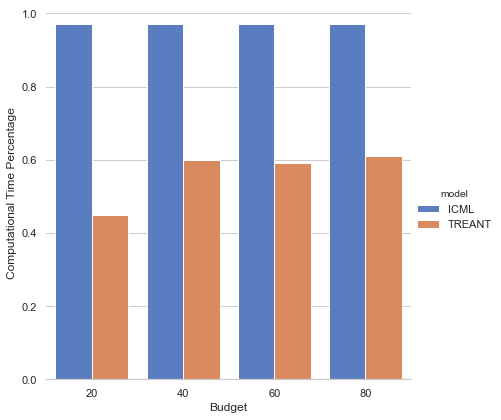

In [231]:
import seaborn as sns
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
d =df_new.groupby(['model'])

g = sns.catplot(x="Budget", y="Ternary", hue="model", data=df_new,
                height=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Computational Time Percentage")


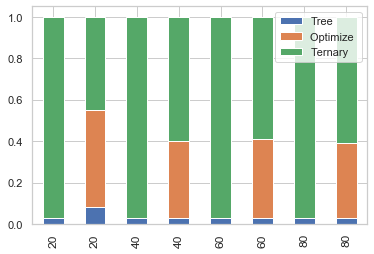

In [249]:

axis = df_new[["Tree","Optimize ","Ternary"]].plot(kind="bar",stacked=True)
plot.xticks([r for r in range(len(df_new['Budget']))],df_new['Budget'].tolist()
                                                        , fontsize=12)

fig = axis.get_figure()